<a href="https://colab.research.google.com/github/Saliss7/CT-213-Mancha-de-Oleo/blob/main/CT_213_Mancha_de_Oleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%pip install openeo
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.5 MB/s eta 0:00:00


In [6]:
# Load the essentials
import openeo
import openeo.processes
import numpy as np

In [8]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=MFBU-VKKR 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [9]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [48.325487506118264, 28.742803969343313],
            [48.325487506118264, 28.414218984218607],
            [48.75387693420447, 28.414218984218607],
            [48.75387693420447, 28.742803969343313],
            [48.325487506118264, 28.742803969343313],
        ]
    ],
}

In [10]:
s1_image = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-08-09", "2017-08-12"],
    spatial_extent=aoi,
    bands=["VV"],
)

s1_image = s1_image.sar_backscatter(coefficient="sigma0-ellipsoid")

In [11]:
s1_image = s1_image.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))

In [12]:
filter_window = np.ones([601, 601])

In [13]:
# calculate factor
factor = 1 / np.prod(filter_window.shape)

In [14]:
thresholds = s1_image.apply_kernel(kernel=filter_window, factor=factor)

In [15]:
threshold_shift = 3.5
thresholds = thresholds - threshold_shift
thresholds = thresholds.rename_labels(dimension="bands", target=["threshold"])

In [16]:
s1_image = s1_image.rename_labels(dimension="bands", target=["amplitude"])
s1_image = s1_image.merge_cubes(thresholds)
oil_spill = s1_image.band("amplitude") < s1_image.band("threshold")

In [17]:
# execute the workflow
oil_spill.execute_batch(title="Oil Spill Data", outputfile="OilSpill.nc")

0:00:00 Job 'j-250706003023424f9c9f96795d12db0c': send 'start'
0:00:17 Job 'j-250706003023424f9c9f96795d12db0c': created (progress 0%)
0:00:25 Job 'j-250706003023424f9c9f96795d12db0c': created (progress 0%)
0:00:35 Job 'j-250706003023424f9c9f96795d12db0c': created (progress 0%)
0:00:47 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:01:00 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:01:16 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:01:36 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:01:59 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:02:26 Job 'j-250706003023424f9c9f96795d12db0c': running (progress N/A)
0:03:00 Job 'j-250706003023424f9c9f96795d12db0c': finished (progress 100%)


<BatchJob job_id='j-250706003023424f9c9f96795d12db0c'>

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import matplotlib.patches as mpatches
from rasterio.plot import show

In [21]:
oilspill = xr.load_dataset("OilSpill.nc")

In [22]:
data = oilspill[["var"]].to_array(dim="bands")

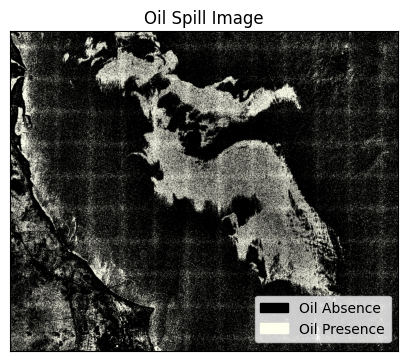

In [23]:
cmap = matplotlib.colors.ListedColormap(["black", "#FFFFED"])
values = ["Absence", "Presence"]
colors = ["black", "#FFFFED"]

oilspill_array = data.squeeze().values[600:-600, 600:-600]
fig, axes = plt.subplots(ncols=1, figsize=(5, 5), dpi=100)
axes.imshow(oilspill_array, vmin=0, vmax=1, cmap=cmap)
axes.set_title("Oil Spill Image")

patches = [
    mpatches.Patch(color=colors[i], label="Oil {l}".format(l=values[i]))
    for i in range(len(values))
]
fig.legend(handles=patches, bbox_to_anchor=(0.9, 0.3), loc=1)
axes.axes.get_xaxis().set_visible(False)
axes.axes.get_yaxis().set_visible(False)